Iteration 1: loglike=-6.040255e+00 (0.005 seconds)
Iteration 2: loglike=-5.947403e+00 (0.004 seconds)
Iteration 3: loglike=-5.905029e+00 (0.004 seconds)
Iteration 4: loglike=-5.885717e+00 (0.004 seconds)
Iteration 5: loglike=-5.877010e+00 (0.004 seconds)
Iteration 6: loglike=-5.873131e+00 (0.004 seconds)
Iteration 7: loglike=-5.871422e+00 (0.004 seconds)
Iteration 8: loglike=-5.870674e+00 (0.004 seconds)
Iteration 9: loglike=-5.870350e+00 (0.004 seconds)
Iteration 10: loglike=-5.870209e+00 (0.003 seconds)
 ~ Dirichlet(alpha)
  alpha =
[ 1.          4.94483965  2.05516035]
 ~ Categorical(p)
  p = 
[[ 0.          0.73620991  0.26379009]
 [ 0.          0.73620991  0.26379009]
 [ 0.          0.73620991  0.26379009]
 [ 0.          0.73620991  0.26379009]
 [ 0.          1.          0.        ]]



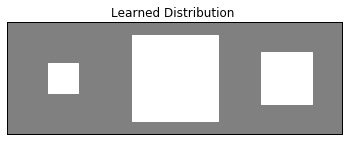

In [188]:

import bayespy as bp


# Concentration parameter
# adding parameter to share information between the different timezones
p_conc_01 = nodes.DirichletConcentration(3)
p_conc_01.initialize_from_value(np.ones(3))
p = bp.nodes.Dirichlet(p_conc_01)
#p = bp.nodes.Dirichlet([1,1,1]) # wito
locations = bp.nodes.Categorical(p, plates=(5,))
observations = bp.nodes.Mixture(
    locations,
    bp.nodes.Bernoulli,
    [
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.0],
    ]
)
observations.observe([True, True, True, True, True])
Q = bp.inference.VB(observations, locations, p)
Q.update(repeat=10)
print(p)
print(locations)

%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p)
bpplt.pyplot.title("Learned Distribution ")
bpplt.pyplot.show()

# Learning from no data

The major problem we faced for the data collection in real world for the thesis was occlussion.
Consider a real world kitchen, all the objects cups, plates, bowls etc are always inside cabinets, washing machine etc occlluded from direct vision. 

We needed to learn from this non availability of data. But how can you learn when there is no data.

Lets make a small example of this problem. Our domestic robot is trying to model the object location of a cup. The cup can be on 3 locations the workspace, dishwasher or cabinet.
We start with equal probabilities as prior [0.33, 0.33, 0.33]
Now the dishwasher and the cabinet are occluded spaces and the domestic robot hardly gets any reading of the object location in these locations. But it can always see the workspace. 
The robot went to the workstation 3 times in the whole day and finds the cup only during the afternoon. Based on this observation we run our inference and the posterior probability looks like this [0.5, 0.7, 0.5] for the afternoon. No changes in the morning and the evening.

But this is the partial truth the robot saw something in morning and evening. The robot saw nothing in the morning and evening. This information can be used to infer about the probable location of the cup during the same time.



After the observation the posterior distribution decreases the probability of finding cup on workspace in morning 



  is_present  location timezone  timezone_index  location_index
0       True   kitchen    night               2               0
1       True  platform  morning               0               2
2       True   kitchen    night               2               0
3      False   kitchen  morning               0               0
4      False   kitchen  morning               0               0
5       True  platform  morning               0               2
6      False      sink    night               2               1
7      False      sink  morning               0               1
8      False      sink    night               2               1
9      False  platform      day               1               2


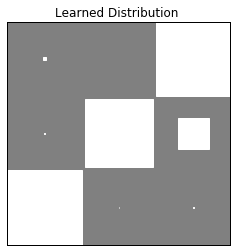

In [189]:
# Some constatnts we will be using 

n_locations = 3 #Number of colors in each bag
locations_dict = {0:'kitchen', 1:'sink', 2:'platform'}
n_timezones = 3 # Number of bags
time_dict = {0:'morning', 1:'day', 2:'night'}
n_trials = 20

from bayespy import nodes
import numpy as np
import pandas as pd

alpha = 1e-1 * np.ones(n_locations)
#Generate some random distributions for the color distribution inside each bags
p_locations = nodes.Dirichlet(alpha,
                          plates = (n_timezones,)).random()
timezone_index = nodes.Categorical((1/n_timezones)*np.ones(n_timezones), plates=(10,)).random()
location_index = nodes.Categorical((1/n_locations)*np.ones(n_locations), plates=(10,)).random()
is_object_present = nodes.Bernoulli(p_locations[timezone_index, location_index]).random()
#np.column_stack([time[timezone_index], locations[location_index], is_object_present])

object_location_dataset = pd.DataFrame({'is_present' : is_object_present,
                                        'timezone' : timezone_index,
                                        'location' : location_index})

object_location_dataset['timezone'] = object_location_dataset['timezone'].map(time_dict)
object_location_dataset['location'] = object_location_dataset['location'].map(locations_dict)
object_location_dataset['is_present'] = object_location_dataset['is_present'].astype(bool)

#Adding for learning without bernouli hack
object_location_dataset['timezone_index'] = timezone_index
object_location_dataset['location_index'] = location_index
print (object_location_dataset)
#data["test"] = data["A"].map(map_dict)

%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p_locations)
bpplt.pyplot.title("Learned Distribution ")
bpplt.pyplot.show()

In [190]:
import bayespy as bp


# Concentration parameter
# adding parameter to share information between the different timezones
p_conc_01 = nodes.DirichletConcentration(n_locations)
p_conc_01.initialize_from_value(np.ones(n_locations))
#location_probabilities = [  bp.nodes.Dirichlet(p_conc_01) ] * n_timezones
location_probabilities = [] #[bp.nodes.Dirichlet([1,1,1]) ] * n_timezones # wito
location_categories = []
observations = []
for index, time in time_dict.items():
    # create location probabiliees
    location_probabilities.append(bp.nodes.Dirichlet(p_conc_01))
    #location_probabilities.append(bp.nodes.Dirichlet([0.1, 0.1, 0.1]))
    
    
    #create the updated data format
    bernoulli_data_format = np.zeros((n_trials, n_locations))
    temp = object_location_dataset[object_location_dataset['timezone'] == time].as_matrix()
    #temp = object_location_dataset[(object_location_dataset['timezone'] == time) 
    #                               & (object_location_dataset['is_present'] == True)].as_matrix()
    bernoulli_data_format = np.zeros((temp.shape[0], n_locations))
    for count, [is_present, location, _, _, _] in enumerate(temp):
        key = [key for key, location_name in locations_dict.items() if location_name == location][0]
        if is_present:
            bernoulli_data_format[count][key] = 0.5
        else :
            bernoulli_data_format[count] = 0.5
            bernoulli_data_format[count][key] = 0.0
            
    location_categories.append(bp.nodes.Categorical(location_probabilities[index],
                                                    plates=(temp.shape[0],)))
    observations.append(bp.nodes.Mixture(
                        location_categories[index],
                        bp.nodes.Bernoulli,
                        bernoulli_data_format.tolist()))
    observations[index].observe([True] * temp.shape[0])
    
   
"""
Q = bp.inference.VB(observations[0], observations[1], observations[2],
                    location_categories[0], location_categories[1], location_categories[2],
                    location_probabilities[0], location_probabilities[1], location_probabilities[2],
                    p_conc_01)
"""
Q = bp.inference.VB(observations[0], location_categories[0], location_probabilities[0], p_conc_01)
Q.update(repeat=100)
print(location_categories[0])
print(location_probabilities[0])
Q = bp.inference.VB(observations[1], location_categories[1], location_probabilities[1], p_conc_01)
Q.update(repeat=100)
print(location_probabilities[1])
Q = bp.inference.VB(observations[2], location_categories[2], location_probabilities[2], p_conc_01)
Q.update(repeat=100)
print(location_probabilities[2])

Iteration 1: loglike=-8.842519e+00 (0.019 seconds)
Iteration 2: loglike=-8.300036e+00 (0.017 seconds)
Iteration 3: loglike=-8.259809e+00 (0.015 seconds)
Iteration 4: loglike=-8.252392e+00 (0.014 seconds)
Iteration 5: loglike=-8.251776e+00 (0.013 seconds)
Iteration 6: loglike=-8.252560e+00 (0.020 seconds)
Converged at iteration 6.
 ~ Categorical(p)
  p = 
[[ 0.          0.          1.        ]
 [ 0.          0.15850047  0.84149953]
 [ 0.          0.15850047  0.84149953]
 [ 0.          0.          1.        ]
 [ 0.12616924  0.          0.87383076]]

 ~ Dirichlet(alpha)
  alpha =
[ 1.23890875  1.47833128  6.10231161]
Iteration 1: loglike=-3.669296e+00 (0.013 seconds)
Iteration 2: loglike=-3.640822e+00 (0.013 seconds)
Iteration 3: loglike=-3.637038e+00 (0.012 seconds)
Iteration 4: loglike=-3.636404e+00 (0.017 seconds)
Iteration 5: loglike=-3.636282e+00 (0.012 seconds)
Iteration 6: loglike=-3.636259e+00 (0.011 seconds)
Converged at iteration 6.
 ~ Dirichlet(alpha)
  alpha =
[ 1.74648923  1.

/home/deebuls/anaconda3/lib/python3.5/site-packages/bayespy/inference/vmp/vmp.py:734: UserWarning: Lower bound decreased 7.839547e-04! Bug somewhere or numerical inaccuracy?
  "numerical inaccuracy?" % L_diff)


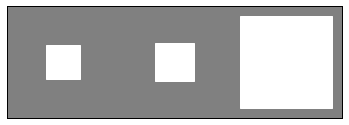

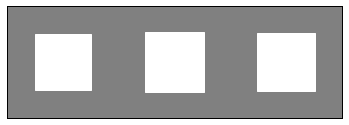

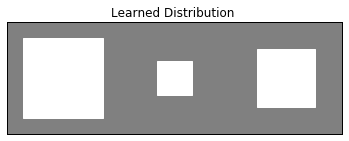

In [191]:
%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(location_probabilities[0])
bpplt.pyplot.show()
bpplt.hinton(location_probabilities[1])
bpplt.pyplot.show()
bpplt.hinton(location_probabilities[2])
bpplt.pyplot.title("Learned Distribution ")
bpplt.pyplot.show()

In [192]:

for index in time_dict.keys():
    beta = p_locations[index]
    alpha = location_probabilities[index].get_parameters()[0]

    D = np.log2(0.5*sum(alpha) + 0.5*sum(beta)) + \
        0.5*sum(np.log2(alpha)) + 0.5*sum(np.log2(beta)) - \
        sum(np.log2(np.add(alpha, beta) / 2)) - \
        0.5 * np.log2(sum(alpha)) + \
        0.5 * np.log2(sum(beta))
        
    print (' Bhatta KL  :', D)

 Bhatta KL  : -22.7016735366
 Bhatta KL  : -6.54352672544
 Bhatta KL  : -12.90359705


T.W. Rauber, A. Conci, T. Braun, and K. Berns.  Bhattacharyya probabilistic
distance of the dirichlet density and its application to split-and-merge image seg-
mentation. In
WSSIP08
, pages 145–148, 2008.

Bhattacharyya distance
We adopt the Bhattacharyya distance [4] to quantify the similarity between at-
tack types distributions. The Bhattacharyya distance is a measure of divergence
between probability distributions, that allows measuring the dissimilarity be-
tween two continuous or discrete probability distributions. As such, it goes from
zero (when the compared distributions are identical) to infinite (when there is
no overlap between the compared distributions). For continuous probability dis-
tributions, it is defined as follows:

![](images/bhatta-Dirichlet.png)

In [193]:
# Comparing KL Divergancedirichlet 
'''
http://bariskurt.com/kullback-leibler-divergence-between-two-dirichlet-and-beta-distributions/
'''
import scipy.special

for index in time_dict.keys():
    alpha = p_locations[index]
    beta = location_probabilities[index].get_parameters()[0]
    D = scipy.special.gammaln(sum(alpha)) - \
        scipy.special.gammaln(sum(beta)) - \
        sum(scipy.special.gammaln(alpha)) + \
        sum(scipy.special.gammaln(beta)) +  \
        (alpha - beta) * (scipy.special.psi(alpha) - scipy.special.psi(sum(alpha)))
    print ('D : ', D)

D :  [  6.45497546e+02   1.42967469e+12  -3.93731508e+01]
D :  [  1.80770776e+04  -1.47361566e+01  -6.14884499e+00]
D :  [ -2.68570159e+01   1.53691249e+05   9.42335096e+03]


In [194]:
# Bhattacharya distance

from scipy.special import gammaln
import numpy as np

alpha = p_locations[0]
beta = location_probabilities[0].get_parameters()[0]
beta = alpha
'''
D = - gammaln(sum(np.add(alpha, beta)/2)) + \
    0.5*(sum(gammaln(alpha)) + sum(gammaln(beta))) - \
    sum(gammaln(np.add(alpha, beta) / 2)) -  \
    0.5*(gammaln(alpha) + gammaln(beta))
'''  
D = - np.log2(sum(np.add(alpha, beta)/2)) + \
    0.5*(sum(np.log2(alpha)) + sum(np.log2(beta))) - \
    sum(np.log2(np.add(alpha, beta) / 2)) -  \
    0.5*(np.log2(alpha) + np.log2(beta))
print (D)

[  9.11276254e+00   3.98148545e+01   2.60826789e-03]


Iteration 1: loglike=-3.583519e+00 (0.002 seconds)
Iteration 2: loglike=-3.583519e+00 (0.002 seconds)
Converged at iteration 2.


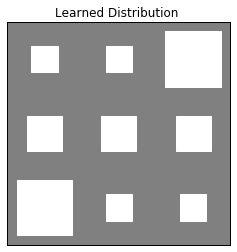

In [195]:

p_conc = bp.nodes.DirichletConcentration(n_locations)
p_conc.initialize_from_value(np.ones(n_locations))
#p_theta = bp.nodes.Dirichlet(p_conc,
p_theta = bp.nodes.Dirichlet(np.ones(n_locations)*1,
                          plates=(n_timezones,),
                          name='p_theta')

only_true_object_location = object_location_dataset[object_location_dataset['is_present'] == True]
n_observations = only_true_object_location.shape[0]
recordings_time = only_true_object_location['timezone_index'].as_matrix().reshape((n_observations, 1))

Y = nodes.Mixture(recordings_time, nodes.Categorical, p_theta)

#Observe Data
Y.observe(only_true_object_location['location_index'].reshape((n_observations, 1)))

#Inference
#Q = bp.inference.VB(Y, p_theta, p_conc)
Q = bp.inference.VB(Y, p_theta)
Q.update(repeat=1000)


%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p_theta)
bpplt.pyplot.title("Learned Distribution ")
bpplt.pyplot.show()

In [196]:
for index in time_dict.keys():
    beta = p_locations[index]
    alpha = p_theta.get_parameters()[0][0]

    D1 = np.log2(0.5*sum(alpha) + 0.5*sum(beta)) + \
        0.5*sum(np.log2(alpha)) + 0.5*sum(np.log2(beta)) - \
        sum(np.log2(np.add(alpha, beta) / 2)) - \
        0.5 * np.log2(sum(alpha)) + \
        0.5 * np.log2(sum(beta))

    beta = p_locations[index]
    alpha = location_probabilities[index].get_parameters()[0]

    D2 = np.log2(0.5*sum(alpha) + 0.5*sum(beta)) + \
        0.5*sum(np.log2(alpha)) + 0.5*sum(np.log2(beta)) - \
        sum(np.log2(np.add(alpha, beta) / 2)) - \
        0.5 * np.log2(sum(alpha)) + \
        0.5 * np.log2(sum(beta))
        
    print (' Bhatta KL  : ', D1, " ", D2 )

 Bhatta KL  :  -22.2505848626   -22.7016735366
 Bhatta KL  :  -6.38194803829   -6.54352672544
 Bhatta KL  :  -12.6957560388   -12.90359705


# Using concentration + beta-bernoulli